In [29]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

import bemcs

class els_labels:
    def __init__(self, els, H, L):
        xmid = np.copy(els.x_centers)
        ymid = np.copy(els.y_centers)
        self.top = ymid == H  # top
        self.right = xmid == L  # right
        self.bot = ymid == -H  # top
        self.left = xmid == -L  # left
        self.interior = (xmid > -L) & (xmid < L) & (ymid > -H) & (ymid < H)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Wavy fault in a box
Below we consider a toy problem based on laboratory rock deformation experiments. A sinusoidal fault is embedded inside a rectangular uniform elastic rectangular box. 

The boundary conditions for this problem are as follows:
- $u_x = 1, u_y = 0$ at the top
- $u_x = -1, u_y = 0$ at the bottom
- traction-free boundary conditions ($\tau_x,\tau_y = 0$) on the left & right boundaries 
- Either traction-free OR static friction boundary conditions (specify $\tau_x,\tau_y$) at interior fault elements

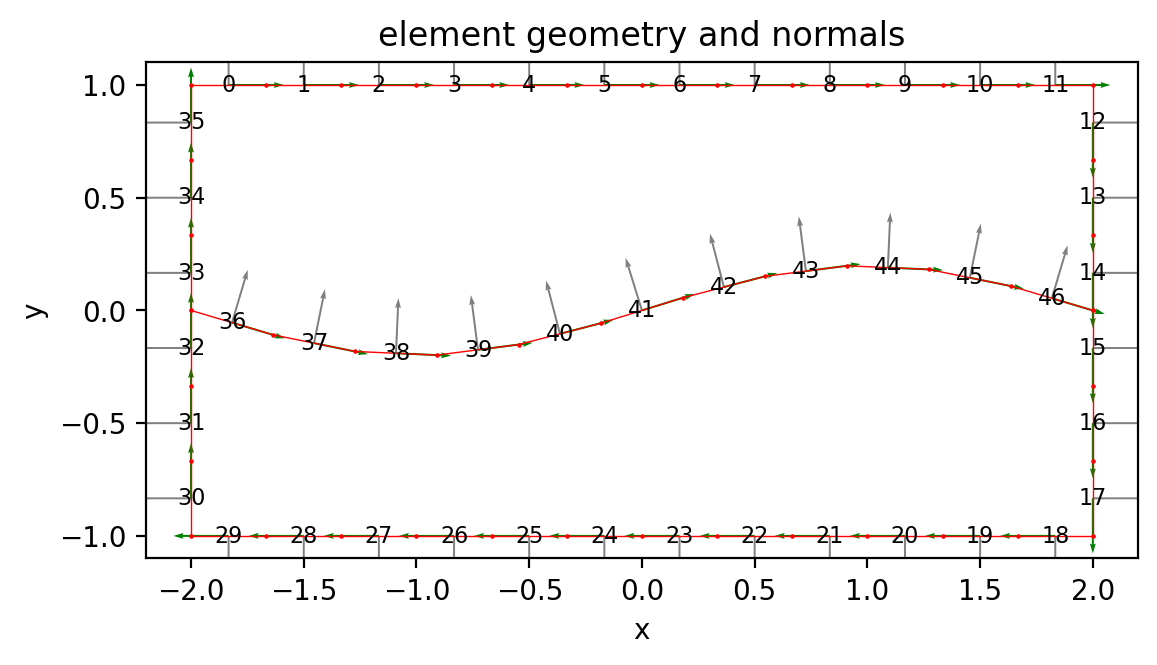

In [30]:
# Elastic parameters
mu = 1
nu = 0.25

# Create a box mesh with a sinusoidal fault in the middle
L = 2.0
H = 1.0
ngrid = 3
corners = np.array([[-L, H], [L, H], [L, -H], [-L, -H], [-L, H]])

# Create arrays of the x and y coordinates of the corners
x, z = [], []
for i in range(4):
    lsegment = np.sqrt(
        (corners[i, 0] - corners[(i + 1), 0]) ** 2
        + (corners[i, 1] - corners[(i + 1), 1]) ** 2
    )
    xi = np.linspace(
        corners[i][0],
        corners[(i + 1) % 4][0],
        num=round(lsegment * ngrid / H),
        endpoint=False,
    )
    zi = np.linspace(
        corners[i][1],
        corners[(i + 1) % 4][1],
        num=round(lsegment * ngrid / H),
        endpoint=False,
    )
    x.append(xi)
    z.append(zi)
x.append(corners[0, 0])
z.append(corners[0, 1])
x = np.hstack(x)
z = np.hstack(z)

x1_box = x[0:-1]
x2_box = x[1:]
y1_box = z[0:-1]
y2_box = z[1:]

# Across the middle: Create a sinusoidal fault centered around y=0
x = np.linspace(-1.0 * L, 1.0 * L, int(2 * L / H * ngrid))
z = 0.2 * H * np.sin(2 * np.pi * x / 2 / L)
# Force the first and last z-values to be 0
z[0] = 0
z[-1] = 0
x1_across = x[0:-1]
x2_across = x[1:]
y1_across = z[0:-1]
y2_across = z[1:]

els = bemcs.initialize_els()
els.x1 = np.concatenate([x1_box, x1_across])
els.y1 = np.concatenate([y1_box, y1_across])
els.x2 = np.concatenate([x2_box, x2_across])
els.y2 = np.concatenate([y2_box, y2_across])
bemcs.standardize_els_geometry(els)
n_els = len(els.x1)
bemcs.plot_els_geometry(els)


# add labels for top,right,bot,left,interior
labels = els_labels(els, H, L)


## Identifying open nodes, overlapping interior nodes and triple junctions automatically

In [31]:
# first find all unique points
points = np.zeros((2 * n_els, 2))
x1y1 = np.vstack((els.x1, els.y1)).T
x2y2 = np.vstack((els.x2, els.y2)).T
points[0::2, :] = x1y1
points[1::2, :] = x2y2
nvec = np.vstack((els.x_normals, els.y_normals)).T
xmid = np.copy(els.x_centers)
ymid = np.copy(els.y_centers)
unique_points, id_unique = np.unique(points, axis=0, return_index=True)

# Find number of open, 2-overlap & triple junction nodes
index_matrix1 = []
index_matrix2 = []
index_matrix3 = []
for i in range(len(unique_points)):
    pts = unique_points[i, :].reshape(1, -1)

    # Which element(s) contains this point
    id1 = np.where(np.all(pts == x1y1, axis=1))
    id2 = np.where(np.all(pts == x2y2, axis=1))

    # The negative signs are for the triple junction equations
    # s_1 + s_2 + s_3 = 0 with the negative sign going to any 2 elements that are both id1 or id2
    if np.size(id1) == 2:
        id_combo = np.hstack((-id1[0] * 3, id2[0] * 3 + 2))
    elif np.size(id2) == 2:
        id_combo = np.hstack((id1[0] * 3, -(id2[0] * 3 + 2)))
    else:
        id_combo = np.hstack((id1[0] * 3, id2[0] * 3 + 2))

    if np.size(id_combo) == 1:
        index_matrix1.append(id_combo)
    elif np.size(id_combo) == 2:
        index_matrix2.append(id_combo)
    elif np.size(id_combo) == 3:
        index_matrix3.append(id_combo)
    else:
        print(id_combo)
        raise ValueError("Cannot deal with more than 3 lines at a node")

print("Number of open nodes =", len(index_matrix1))
print(":", index_matrix1)
print("Number of 2-overlap nodes =", len(index_matrix2))
print(":", index_matrix2)
print("Number of triple junctions =", len(index_matrix3))
print(":", index_matrix3)

N_c = 2 * n_els  # central node equations
N_o = 2 * len(index_matrix1)  # open node equations
N_i = 4 * len(index_matrix2)  # overlapping node equations
N_t = 6 * len(index_matrix3)  # triple junction equations


Number of open nodes = 0
: []
Number of 2-overlap nodes = 44
: [array([90, 89]), array([93, 92]), array([96, 95]), array([102, 101]), array([105, 104]), array([  0, 107]), array([3, 2]), array([87, 86]), array([111, 110]), array([6, 5]), array([84, 83]), array([114, 113]), array([81, 80]), array([9, 8]), array([117, 116]), array([12, 11]), array([78, 77]), array([120, 119]), array([15, 14]), array([75, 74]), array([123, 122]), array([72, 71]), array([18, 17]), array([126, 125]), array([21, 20]), array([69, 68]), array([129, 128]), array([24, 23]), array([66, 65]), array([132, 131]), array([63, 62]), array([27, 26]), array([135, 134]), array([30, 29]), array([60, 59]), array([138, 137]), array([33, 32]), array([57, 56]), array([54, 53]), array([51, 50]), array([48, 47]), array([42, 41]), array([39, 38]), array([36, 35])]
Number of triple junctions = 2
: [array([ -99, -108,   98]), array([  45,  -44, -140])]


# Boundary Conditions
Here we implement the various boundary conditions as a big vector that goes in the right hand side of the Integral equations. The convention we follow is:
- BCs at node centers
- BCs at open nodes
- BCs at interior 2-overlap nodes
- BCs at triple junctions (this is experimental currently)

In [32]:
# Nequations = N_c + N_o + N_i + N_t
Nequations = N_c + N_o + N_i + N_t
Nunknowns = 6 * n_els

# We will stack this with
# equations for the element centers
# equations at open nodes (RHS = 0)
# equations at overlapping nodes (RHS = 0)
# equations at triple junctions (RHS = 0)
BC_c = np.zeros((N_c, 1))  # these are the only non-zero entries
BC_o = np.zeros((N_o, 1))
BC_i = np.zeros((N_i, 1))
BC_t = np.zeros((N_t, 1))

# Boundary conditions are
# top: ux = 1, uy = 0
# right: traction-free
# bot: ux = -1, uy = 0
# left: traction-free
# interior: traction-free
bc_x = np.zeros((n_els, 1))
bc_y = np.zeros((n_els, 1))

bc_x[labels.top] = 1.0
bc_y[labels.top] = -0.0
bc_x[labels.bot] = -1.0
bc_y[labels.bot] = -0.0

bc_x[labels.right] = -0.0
bc_y[labels.right] = 0.0
bc_x[labels.left] = 0.0
bc_y[labels.left] = 0.0

# traction BCs at interior fault centers (for a flat fault, bc_x = 0.6 and bc_y = 1.0 is like setting Byerlee static friction conditions)
bc_x[labels.interior] = 0.6
bc_y[labels.interior] = 1.0

BC_c[0::2] = bc_x
BC_c[1::2] = bc_y
# stack all the BCs into 1 big vector
BCvector = np.vstack((BC_c, BC_o, BC_i, BC_t))


# Design Matrix System 
Here we implement various boundary conditions at the different types of nodes we have
- At element centers, we implement either displacement or traction boundary conditions
- At open nodes, we force slip to be 0
- At 2-overlap (interior) nodes we have continuity & smoothness of slip
- At triple junctions, we are currently implementing 2 equations for conservation of slip and 4 equations for smoothness (these choices are likely to change in the future)

In [33]:
# Design matrices (in x,y coordinates) for slip and slip gradients at each 3qn
matrix_slip, matrix_slip_gradient = bemcs.get_matrices_slip_slip_gradient(
    els, flag="node"
)

# Patch center locations (need to be shifted an infinitesimal amount in -ve unit normal direction)
obs_xy = np.vstack((xmid, ymid)).T - nvec * 1e-8
x_obs = obs_xy[:, 0].reshape(-1, 1)
y_obs = obs_xy[:, 1].reshape(-1, 1)

# Compute shear and tensile stress kernels evaluated ONLY at the center of each element
kernels_s = bemcs.get_displacement_stress_kernel(x_obs, y_obs, els, mu, nu, "shear")
kernels_n = bemcs.get_displacement_stress_kernel(x_obs, y_obs, els, mu, nu, "normal")

# Convert to traction kernels [Nobs x Ncoefficients]
traction_kernels_s = bemcs.get_traction_kernels(els, kernels_s)
traction_kernels_n = bemcs.get_traction_kernels(els, kernels_n)

# Linear Operators for the appropriate boundary conditions
matrix_system_c = np.zeros((N_c, Nunknowns))
matrix_system_o = np.zeros((N_o, Nunknowns))
matrix_system_i = np.zeros((N_i, Nunknowns))
matrix_system_t = np.zeros((N_t, Nunknowns))

# Linear operator for central node BCs
kerneleval_x = np.zeros((n_els, Nunknowns))
kerneleval_y = np.zeros((n_els, Nunknowns))

for i in range(5):
    if i == 0:
        idx = labels.top.flatten()
        kernel_for_x_s = kernels_s[3]
        kernel_for_x_n = kernels_n[3]
        kernel_for_y_s = kernels_s[4]
        kernel_for_y_n = kernels_n[4]
    elif i == 1:
        idx = labels.bot.flatten()
        kernel_for_x_s = kernels_s[3]
        kernel_for_x_n = kernels_n[3]
        kernel_for_y_s = kernels_s[4]
        kernel_for_y_n = kernels_n[4]
    elif i == 2:
        idx = labels.left.flatten()
        kernel_for_x_s = traction_kernels_s[0]
        kernel_for_x_n = traction_kernels_n[0]
        kernel_for_y_s = traction_kernels_s[1]
        kernel_for_y_n = traction_kernels_n[1]
        # kernel_for_x_s = kernels_s[3]
        # kernel_for_x_n = kernels_n[3]
        # kernel_for_y_s = kernels_s[4]
        # kernel_for_y_n = kernels_n[4]
    elif i == 3:
        idx = labels.right.flatten()
        kernel_for_x_s = traction_kernels_s[0]
        kernel_for_x_n = traction_kernels_n[0]
        kernel_for_y_s = traction_kernels_s[1]
        kernel_for_y_n = traction_kernels_n[1]
        # kernel_for_x_s = kernels_s[3]
        # kernel_for_x_n = kernels_n[3]
        # kernel_for_y_s = kernels_s[4]
        # kernel_for_y_n = kernels_n[4]
    else:
        idx = labels.interior.flatten()
        kernel_for_x_s = traction_kernels_s[0]
        kernel_for_x_n = traction_kernels_n[0]
        kernel_for_y_s = traction_kernels_s[1]
        kernel_for_y_n = traction_kernels_n[1]
        # kernel_for_x_s = kernels_s[2]
        # kernel_for_x_n = kernels_n[2]
        # kernel_for_y_s = kernels_s[1]
        # kernel_for_y_n = kernels_n[1]
    # print(idx)
    # x-kernels
    kerneleval_x[idx, 0::6] = kernel_for_x_s[idx, 0::3]
    kerneleval_x[idx, 1::6] = kernel_for_x_s[idx, 1::3]
    kerneleval_x[idx, 2::6] = kernel_for_x_s[idx, 2::3]
    kerneleval_x[idx, 3::6] = kernel_for_x_n[idx, 0::3]
    kerneleval_x[idx, 4::6] = kernel_for_x_n[idx, 1::3]
    kerneleval_x[idx, 5::6] = kernel_for_x_n[idx, 2::3]

    # y-kernels
    kerneleval_y[idx, 0::6] = kernel_for_y_s[idx, 0::3]
    kerneleval_y[idx, 1::6] = kernel_for_y_s[idx, 1::3]
    kerneleval_y[idx, 2::6] = kernel_for_y_s[idx, 2::3]
    kerneleval_y[idx, 3::6] = kernel_for_y_n[idx, 0::3]
    kerneleval_y[idx, 4::6] = kernel_for_y_n[idx, 1::3]
    kerneleval_y[idx, 5::6] = kernel_for_y_n[idx, 2::3]

# populate matrix_system for central nodes
matrix_system_c[0::2, :] = kerneleval_x
matrix_system_c[1::2, :] = kerneleval_y


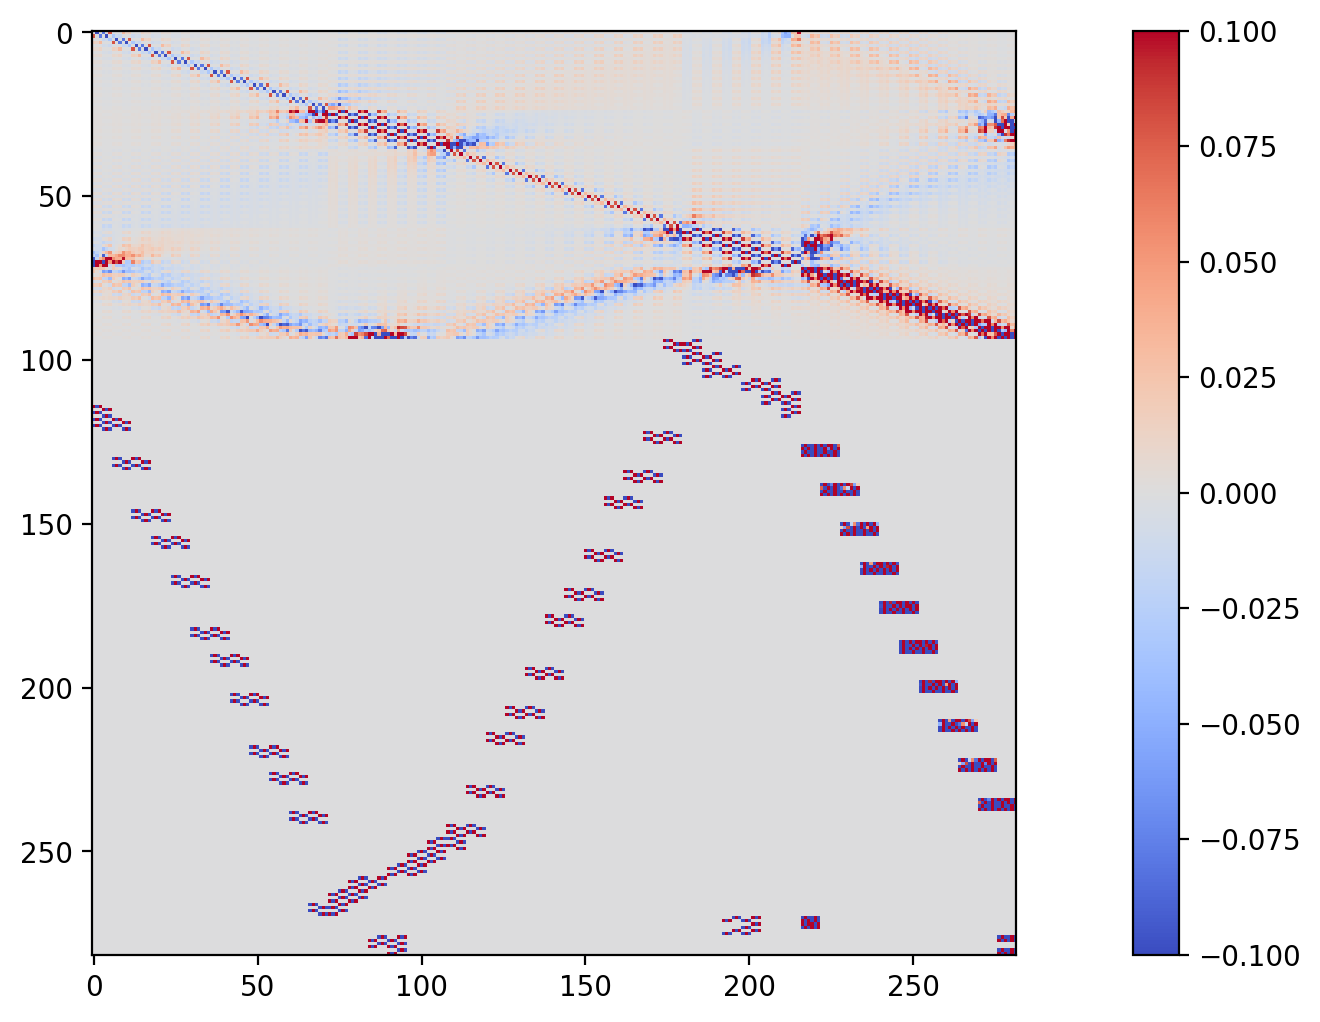

In [34]:
# Linear operator for open nodes
for i in range(int(N_o / 2)):
    id1 = index_matrix1[i]  # node number
    matrix_system_o[2 * i, :] = matrix_slip[2 * id1, :]  # x component
    matrix_system_o[2 * i + 1, :] = matrix_slip[2 * id1 + 1, :]  # y component

# Linear operator for overlapping nodes
for i in range(int(N_i / 4)):
    idvals = index_matrix2[i]  # node number
    # continuity condition
    matrix_system_i[4 * i, :] = (
        matrix_slip[2 * idvals[0], :] - matrix_slip[2 * idvals[1], :]
    )  # x
    matrix_system_i[4 * i + 1, :] = (
        matrix_slip[2 * idvals[0] + 1, :] - matrix_slip[2 * idvals[1] + 1, :]
    )  # y
    # smoothing constraints
    matrix_system_i[4 * i + 2, :] = (
        matrix_slip_gradient[2 * idvals[0], :] - matrix_slip_gradient[2 * idvals[1], :]
    )  # x
    matrix_system_i[4 * i + 3, :] = (
        matrix_slip_gradient[2 * idvals[0] + 1, :]
        - matrix_slip_gradient[2 * idvals[1] + 1, :]
    )  # y

# Linear operator for triple junction nodes
for i in range(int(N_t / 6)):
    id1 = index_matrix3[i]
    idvals = np.abs(id1)

    id_neg = idvals[id1 < 0]  # node number that need to be subtracted in TJ kinematics
    id_pos = idvals[id1 >= 0]  # node numbers that need to be added
    # triple junction kinematics equations
    if len(id_neg) == 2:
        matrix_system_t[6 * i, :] = (
            matrix_slip[2 * id_pos, :]
            - matrix_slip[2 * id_neg[0], :]
            - matrix_slip[2 * id_neg[1], :]
        )  # x component
        matrix_system_t[6 * i + 1, :] = (
            matrix_slip[2 * id_pos + 1, :]
            - matrix_slip[2 * id_neg[0] + 1, :]
            - matrix_slip[2 * id_neg[1] + 1, :]
        )  # y component
    else:
        matrix_system_t[6 * i, :] = (
            matrix_slip[2 * id_pos[0], :]
            + matrix_slip[2 * id_pos[1], :]
            - matrix_slip[2 * id_neg, :]
        )  # x component
        matrix_system_t[6 * i + 1, :] = (
            matrix_slip[2 * id_pos[0] + 1, :]
            + matrix_slip[2 * id_pos[1] + 1, :]
            - matrix_slip[2 * id_neg + 1, :]
        )  # y component

    # smoothing constraints (2 nodes at a time)
    matrix_system_t[6 * i + 2, :] = (
        matrix_slip_gradient[2 * idvals[0], :] - matrix_slip_gradient[2 * idvals[1], :]
    )  # x
    matrix_system_t[6 * i + 3, :] = (
        matrix_slip_gradient[2 * idvals[0] + 1, :]
        - matrix_slip_gradient[2 * idvals[1] + 1, :]
    )  # y
    matrix_system_t[6 * i + 4, :] = (
        matrix_slip_gradient[2 * idvals[0], :] - matrix_slip_gradient[2 * idvals[2], :]
    )  # x
    matrix_system_t[6 * i + 5, :] = (
        matrix_slip_gradient[2 * idvals[0] + 1, :]
        - matrix_slip_gradient[2 * idvals[2] + 1, :]
    )  # y

# stack the matrices and create the full linear operator
matrix_system = np.vstack(
    (matrix_system_c, matrix_system_o, matrix_system_i, matrix_system_t)
)

# plot design matrix
plt.figure(figsize=(15, 6))
plt.imshow(matrix_system, cmap="coolwarm")
plt.colorbar()
plt.clim(-0.1, 0.1)
plt.show()


# Solve system

In [35]:
# compute quadratic node coefficients (in local (s,n) coordinates)
quadratic_coefs = np.linalg.inv(matrix_system) @ BCvector
print("Linear Operator Condition Number:", np.linalg.cond(matrix_system))

# extract (s,n) components and store them in 2 separate vectors
quadratic_coefs_s = np.zeros((3 * n_els, 1))
quadratic_coefs_n = np.zeros((3 * n_els, 1))
for i in range(n_els):
    quadratic_coefs_s[3 * i : 3 * (i + 1)] = quadratic_coefs[6 * i : 6 * i + 3]
    quadratic_coefs_n[3 * i : 3 * (i + 1)] = quadratic_coefs[6 * i + 3 : 6 * (i + 1)]


Linear Operator Condition Number: 605.9381351026836


# Plot displacement and stress components in the medium

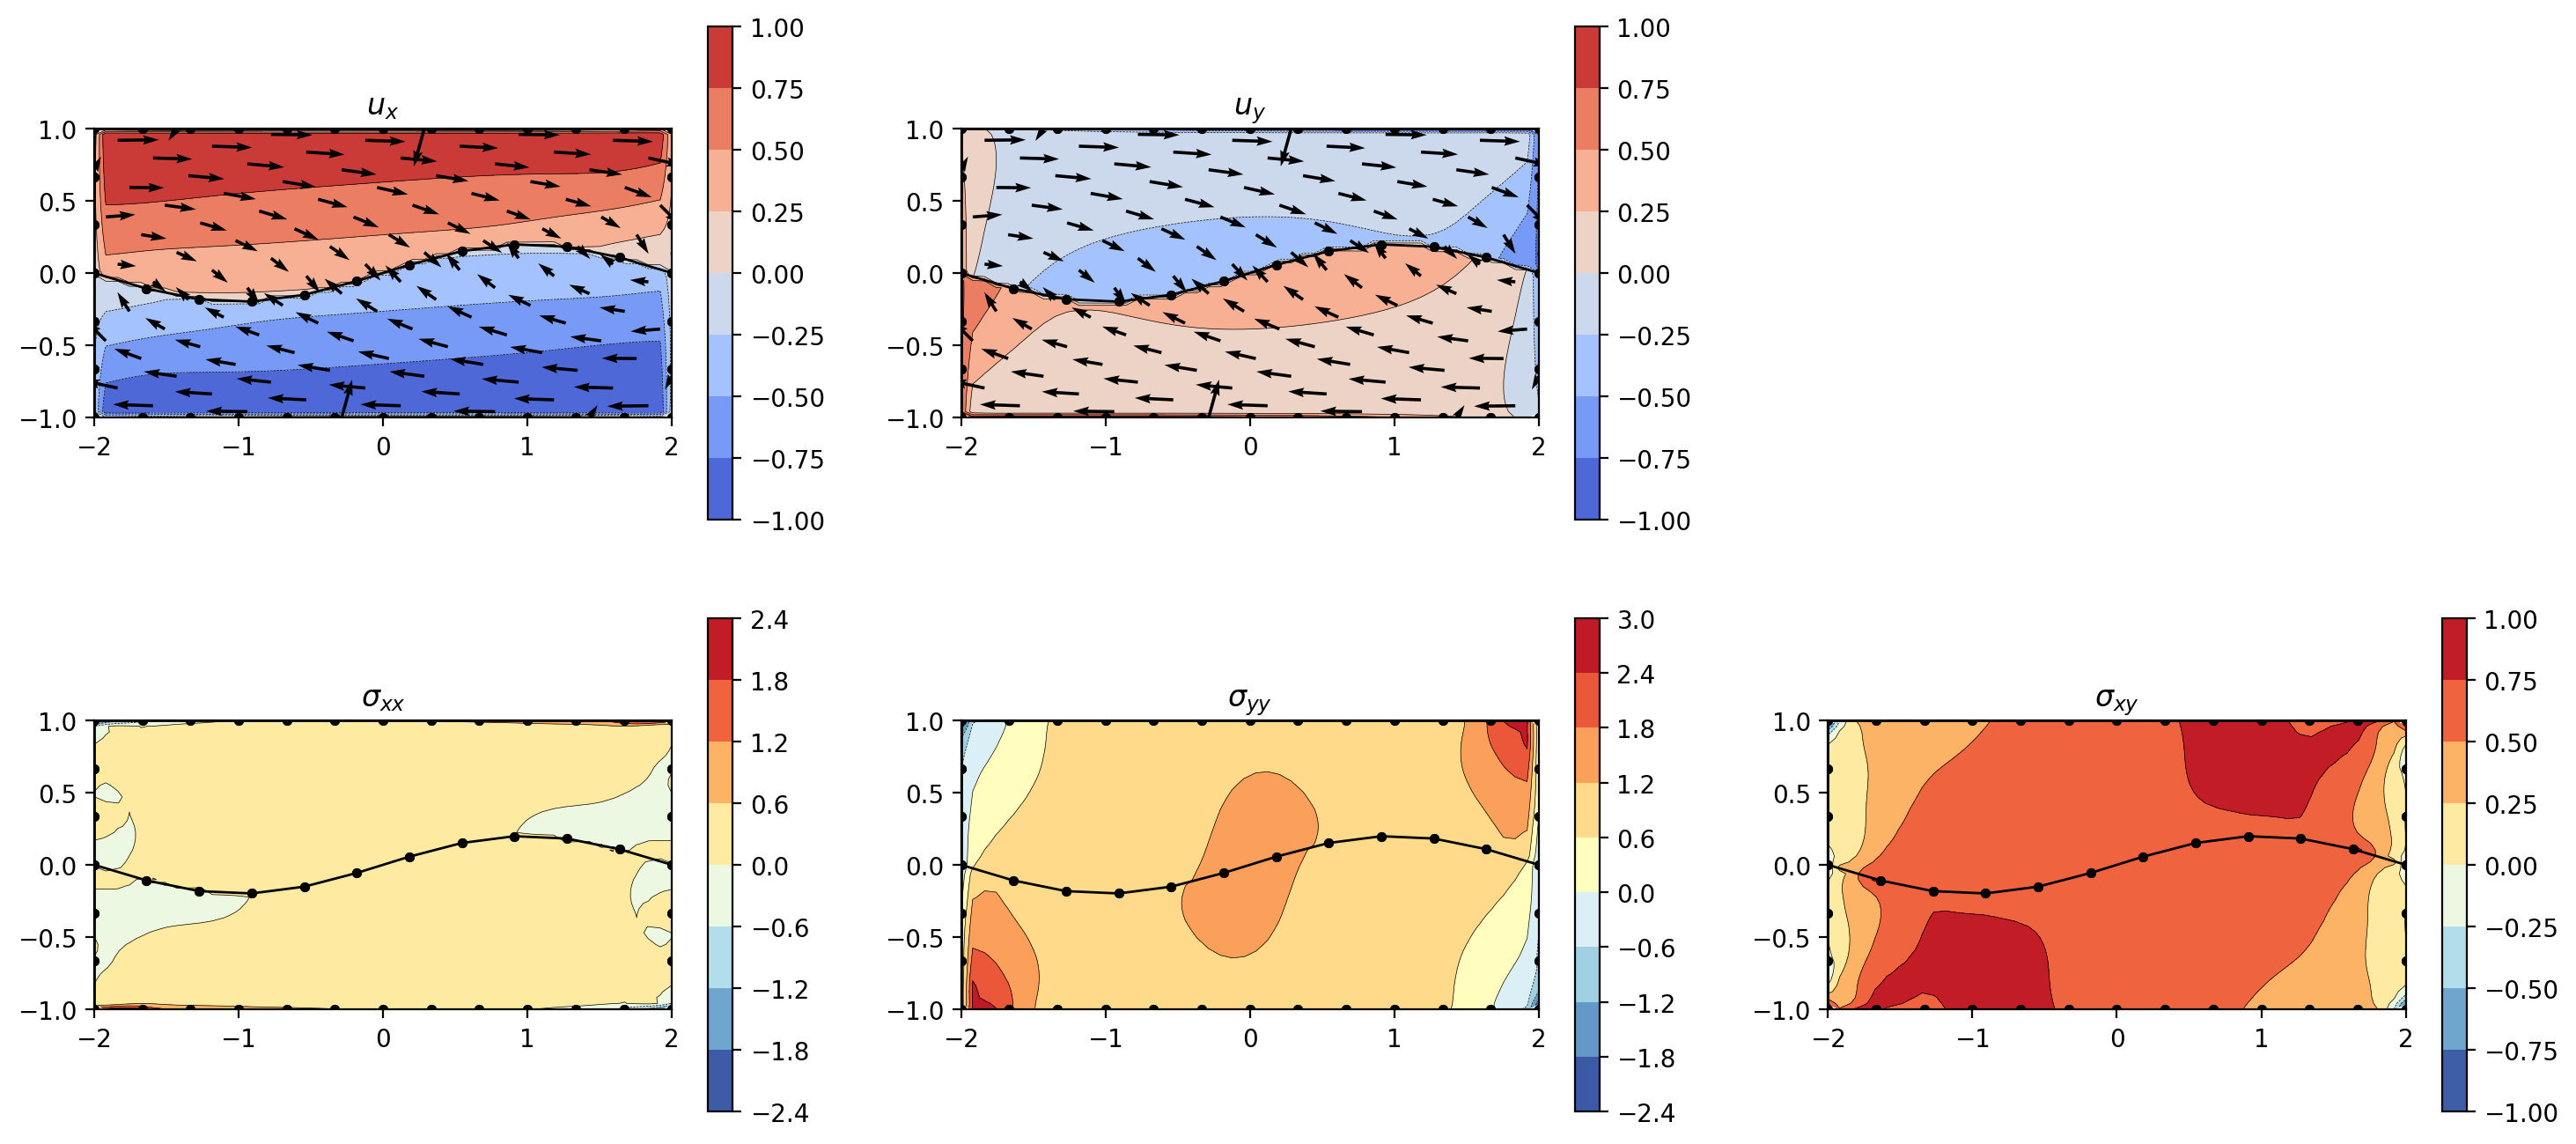

In [36]:
# Observation points
n_obs = 50
width = 2
x_obs = np.linspace(-width, width, n_obs)
y_obs = np.linspace(-width / 2, width / 2, n_obs)
x_obs, y_obs = np.meshgrid(x_obs, y_obs)
x_obs = x_obs.flatten()
y_obs = y_obs.flatten()

# Compute shear and tensile stress kernels
kernels_s = bemcs.get_displacement_stress_kernel(x_obs, y_obs, els, mu, nu, "shear")
kernels_n = bemcs.get_displacement_stress_kernel(x_obs, y_obs, els, mu, nu, "normal")

# Compute displacement and stresses (we will plot it later)
ux = kernels_s[3] @ quadratic_coefs_s + kernels_n[3] @ quadratic_coefs_n
uy = kernels_s[4] @ quadratic_coefs_s + kernels_n[4] @ quadratic_coefs_n
sxx = kernels_s[0] @ (quadratic_coefs_s) + kernels_n[0] @ quadratic_coefs_n
syy = kernels_s[1] @ quadratic_coefs_s + kernels_n[1] @ quadratic_coefs_n
sxy = kernels_s[2] @ quadratic_coefs_s + kernels_n[2] @ quadratic_coefs_n

# n_skip_plot = 21
bemcs.plot_displacements_stresses_els(
    els, n_obs, ux, uy, sxx, syy, sxy, x_obs, y_obs, n_skip_plot=21
)


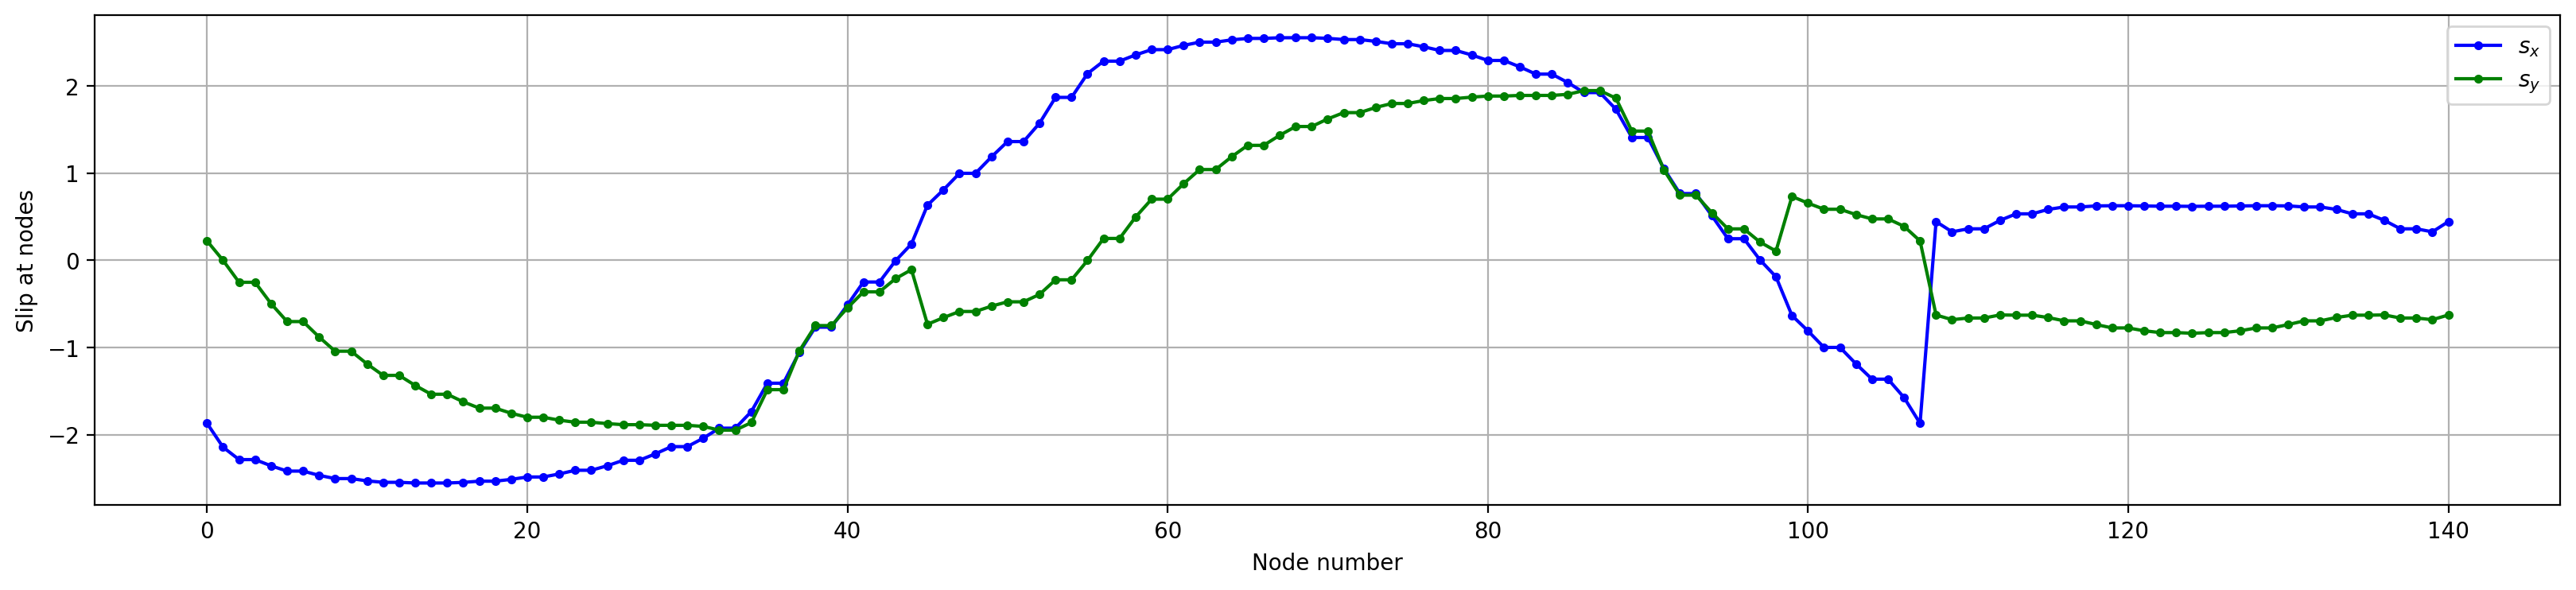

In [37]:
# Extract slip at nodes from quadratic coefficients
slip_nodes = matrix_slip @ quadratic_coefs
slip_nodes_x = slip_nodes[0::2]
slip_nodes_y = slip_nodes[1::2]
slip_vector = np.hstack((slip_nodes_x, slip_nodes_y))

# Rotate from (x,y) to (s,n) for slip vector
slip_nodes_s = np.zeros((3 * n_els, 1))
slip_nodes_n = np.zeros((3 * n_els, 1))

for i in range(n_els):
    dummy = slip_vector[3 * i : 3 * (i + 1), :] @ els.rot_mats[i, :, :]
    slip_nodes_s[3 * i : 3 * (i + 1), 0] = dummy[:, 0]
    slip_nodes_n[3 * i : 3 * (i + 1), 0] = dummy[:, 1]

plt.figure(figsize=(20, 4))
plt.plot(slip_nodes_x, "b.-", label="$s_x$")
plt.plot(slip_nodes_y, "g.-", label="$s_y$")
plt.xlabel("Node number")
plt.ylabel("Slip at nodes")
plt.legend()
plt.grid()
plt.show()
